## Motivation

Following “good regulator” theorem, if an agent is to regulate the state of its environment efficiently (e.g. satisfy a user), then it must internalize a model of its
environment. The environment can be represented by a probabilistic model. Depending on the task (the objective of the application) the model will differ. In this notebook we consider speech enhancement task meaning that we need a model to encode the speech signal.

Before we move on the model specification, we have to settle on a signal representation. 
Most common ones are: frequency, time-frequency, and time domain representations.  We are make us of the latter type of the representation of an audio signal (*waveform modelling currently seems to be the dominant approach in the generative setting; "Generating music in the waveform domain" Sander Dieleman*) 


It turns out that time-varying AR model (**TVAR**) is a good representation of a speech signal:

\begin{align}  &\mathbf{x}_t = A(\theta_{T})\mathbf{x}_{t-1} + \mathbf{c}v_{t} \\ &y_t = \mathbf{c}^{\top} \mathbf{x}_{t} + w_t \end{align} where 

\begin{align} &v_t \sim \mathcal{N}(0, \gamma^{-1}) \\ &w_t \sim \mathcal{N}(0, \tau^{-1}) \end{align} are process and measurement noise respectively.

$T = div(t, 10)$

In order to approximate the posterior we employ variational message passing (**VMP**)
DISCLAIMER: we use informative prior for measurement noise precision $\tau$

In [1]:
import Pkg
Pkg.status()

      Status `~/Documents/Julia/TVAR_FFG/Project.toml`
  [9fc3f58a] ForneyLab v0.11.2
  [bd7594eb] SampledSignals v2.1.0


In [8]:
##
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov, Multivariate
using LAR.Node
using LAR.Data
using ProgressMeter
using LinearAlgebra
using Plots
using Dates
using WAV
using Random
include("helpers.jl")

loadAR (generic function with 1 method)

In [9]:
# clean speech
cl, fs = wavread("data/speech/clean/sp20.wav")
wavwrite(cl, "data/speech/clean.wav")
# white noise
σ² = 0.0001
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "data/speech/noised.wav")

## Speech Signals

### clean

In [10]:
using SampledSignals
# clean speech
buf_cl = SampleBuf{Float64, 2}(cl, fs)

20752-frame, 1-channel SampleBuf{Float64, 2}
2.594s sampled at 8000.0Hz
▁▁▁▁▃▅▅▃▂▂▆▆▇▆▅▆▆▅▃▂▃▄▆▇▇▆▅▅▅▅▆▅▃▃▆▆▄▁▁▆▆▃▂▂▂▅▅▆▆▆▆▅▅▅▅▃▃▅▅▄▂▃▅▆▇▇▆▆▆▃▃▃▂▂▃▂▁▁▁▁

### noised

In [11]:
# noised speech
buf_ns = SampleBuf{Float64, 2}(ns, fs)

20752-frame, 1-channel SampleBuf{Float64, 2}
2.594s sampled at 8000.0Hz
▄▄▄▄▄▅▅▄▄▄▆▆▇▆▅▆▆▅▄▄▄▄▆▇▇▆▅▅▅▅▅▅▄▄▆▆▄▄▄▆▅▄▄▄▄▅▅▆▆▆▆▅▅▅▅▄▄▅▅▄▄▄▅▆▇▆▆▆▆▄▄▄▄▄▄▄▄▄▄▄

# Batch learning

In [12]:
# dividing into 10ms frames with 2.5ms overlap
start = 1
l = Int(0.01*fs)
overlap = Int(0.0025*fs)
totseg = Int(ceil(length(ns)/(l-overlap)))
segment = zeros(totseg, l)
zseg = zeros(totseg, l)
for i in 1:totseg - 1
    global start
    segment[i,1:l]=ns[start:start+l-1]
    zseg[i, 1:l] = cl[start:start+l-1]
    start = (l-overlap)*i+1
end
segment[totseg, 1:length(ns)-start+1] = ns[start:length(ns)]
zseg[totseg, 1:length(cl)-start+1] = cl[start:length(cl)];

In [13]:
l

80

In [14]:
# RW baseline
function generate_algorithm_rw(n_samples)
    # Building the model
    fg = FactorGraph()

    # State prior
    @RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0), placeholder(:v_x_0))

    @RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

    # Transition and observation model
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)

    x_i_min = x_0
    for i in 1:n_samples

        @RV x[i] ~ GaussianMeanPrecision(x_i_min, γ)

        @RV y[i] ~ GaussianMeanPrecision(x[i], 1/σ²)

        # Data placeholder
        placeholder(y[i], :y, index=i)

        # Reset state for next step
        x_i_min = x[i]
    end
    
    # Introducing instrumental distribution (structured states time)
    q = PosteriorFactorization(x_0, x, γ, ids=[:X0 :X :Γ])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true)
end

generate_algorithm_rw (generic function with 1 method)

In [15]:
function run_inference_rw(segment)
    # VMP iterations
    vmp_its = 20

    # Storage for results
    fe = zeros(totseg, vmp_its)

    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)

    rγ_a, rγ_b = zeros(totseg), zeros(totseg)

    # Priors
    m_x_min_0 = 0.0
    v_x_min_0 = 1.0
    a_γ_0 = 1.0
    b_γ_0 = 0.000001;

    @showprogress for segnum in 1:totseg

        obs = segment[segnum, :]
        n_samples = length(ns)

        data = Dict(:y => obs, :m_x_0 => m_x_min_0, :v_x_0 => v_x_min_0,
                    :a_γ => a_γ_0, :b_γ => b_γ_0)

        # Initial posterior factors
        marginals = Dict{Symbol, ProbabilityDistribution}()
        marginals[:γ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_γ_0, b=b_γ_0)
        for i in 0:n_samples
            marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=0.0, v=1.0)
        end

        # Run algorithm
        for i in 1:vmp_its
            stepX0!(data, marginals)
            stepX!(data, marginals)
            stepΓ!(data, marginals)
            fe[segnum, i] = freeEnergy(data, marginals)
        end

        m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
        insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_0])[1])

        rmx[segnum, :], rvx[segnum, :] = m_x, v_x
        rγ_a[segnum], rγ_b[segnum] = marginals[:γ].params[:a], marginals[:γ].params[:b]

        m_x_min_0 = unsafeMean(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1]
        v_x_min_0 = unsafeCov(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1]

    end
    rmx, rvx, (rγ_a ./ rγ_b), fe
end

run_inference_rw (generic function with 1 method)

In [16]:
function generate_algorithm_ar(ARorder, n_samples)
    # Building the model
    fg = FactorGraph()

    # State prior
    @RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                                   placeholder(:v_x_0, dims=(ARorder, ARorder)))

    @RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                                 placeholder(:v_θ, dims=(ARorder, ARorder)))

    @RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

    # Transition and observation model
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)

    c = zeros(ARorder); c[1] = 1.0

    x_i_min = x_0
    for i in 1:n_samples

        @RV x[i] ~ Autoregressive(θ, x_i_min, γ)

        @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), 1/σ²)

        # Data placeholder
        placeholder(y[i], :y, index=i)

        # Reset state for next step
        x_i_min = x[i]
    end
    
    # Introducing instrumental distribution (structured states time)
    q = PosteriorFactorization(x_0, x, γ, θ, ids=[:X0 :X :Γ :Θ])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true)
end

generate_algorithm_ar (generic function with 1 method)

In [17]:
function run_inference_ar(ARorder, segment)
    # VMP iterations
    vmp_its = 20

    # Storage for results
    fe = zeros(totseg, vmp_its)

    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)

    rmθ = zeros(totseg, ARorder)
    rvθ = zeros(ARorder, ARorder, totseg)

    rγ_a, rγ_b = zeros(totseg), zeros(totseg)

    # Priors
    m_x_min_0 = zeros(ARorder)
    v_x_min_0 = diagm(ones(ARorder))
    m_θ_min_0 = zeros(ARorder)
    v_θ_min_0 = diagm(ones(ARorder))
    a_γ_0 = 1.0
    b_γ_0 = 0.000001;


    @showprogress for segnum in 1:totseg

        obs = segment[segnum, :]
        n_samples = length(ns)

        data = Dict(:y => obs, :m_x_0 => m_x_min_0, :v_x_0 => v_x_min_0,
                    :m_θ => m_θ_min_0, :v_θ => v_θ_min_0,
                    :a_γ => a_γ_0, :b_γ => b_γ_0)

        # Initial posterior factors
        marginals = Dict{Symbol, ProbabilityDistribution}()
        marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=m_θ_min_0, v=v_θ_min_0)
        marginals[:γ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_γ_0, b=b_γ_0)
        for i in 0:n_samples
            marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
        end

        # Run algorithm
        for i in 1:vmp_its
            stepX0!(data, marginals)
            stepX!(data, marginals)
            stepΘ!(data, marginals)
            stepΓ!(data, marginals)
            fe[segnum, i] = freeEnergy(data, marginals)
        end

        m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
        insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_0])[1])

        rmx[segnum, :], rvx[segnum, :] = m_x, v_x
        rmθ[segnum, :], rvθ[:, :, segnum] = unsafeMeanCov(marginals[:θ])
        rγ_a[segnum], rγ_b[segnum] = marginals[:γ].params[:a], marginals[:γ].params[:b]

        m_x_min_0 = unsafeMean(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1:ARorder]
        v_x_min_0 = unsafeCov(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1:ARorder, 1:ARorder]
        m_θ_min_0, v_θ_min_0 = zeros(ARorder), diagm(ones(ARorder))

    end
    rmx, rvx, rmθ, rvθ, (rγ_a ./ rγ_b), fe
end

run_inference_ar (generic function with 1 method)

In [18]:
function generate_algorithm_tvar(ARorder, n_samples)
    # Building the model
    fg = FactorGraph()

    # State prior
    @RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                                   placeholder(:v_x_0, dims=(ARorder, ARorder)))

    @RV θ_0 ~ GaussianMeanVariance(placeholder(:m_θ_0, dims=(ARorder, )),
                                   placeholder(:v_θ_0, dims=(ARorder, ARorder)))

    @RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

    # Transition and observation model
    x = Vector{Variable}(undef, n_samples)
    θ = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)

    c = zeros(ARorder); c[1] = 1.0

    x_i_min = x_0
    θ_i_min = θ_0
    for i in 1:n_samples
        @RV θ[i] ~ GaussianMeanPrecision(θ_i_min, 100*diagm(ones(ARorder)))
        
        @RV x[i] ~ Autoregressive(θ[i], x_i_min, γ)

        @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), 1/σ²)

        # Data placeholder
        placeholder(y[i], :y, index=i)

        # Reset state for next step
        x_i_min = x[i]
        θ_i_min = θ[i]
    end
    
    # Introducing instrumental distribution (structured states time)
    q = PosteriorFactorization(x_0, x, γ, θ_0, θ, ids=[:X0 :X :Γ :Θ0 :Θ])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true)
end

generate_algorithm_tvar (generic function with 1 method)

In [19]:
function run_inference_tvar(ARorder, segment)
    # VMP iterations
    vmp_its = 20

    # Storage for results
    fe = zeros(totseg, vmp_its)

    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)

    rmθ = []
    rvθ = []

    rγ_a, rγ_b = zeros(totseg), zeros(totseg)

    # Priors
    m_x_min_0 = zeros(ARorder)
    v_x_min_0 = diagm(ones(ARorder))
    m_θ_min_0 = zeros(ARorder)
    v_θ_min_0 = diagm(ones(ARorder))
    a_γ_0 = 1.0
    b_γ_0 = 0.000001;


    @showprogress for segnum in 1:totseg

        obs = segment[segnum, :]
        n_samples = length(ns)

        data = Dict(:y => obs, :m_x_0 => m_x_min_0, :v_x_0 => v_x_min_0,
                    :m_θ_0 => m_θ_min_0, :v_θ_0 => v_θ_min_0,
                    :a_γ => a_γ_0, :b_γ => b_γ_0)

        # Initial posterior factors
        marginals = Dict{Symbol, ProbabilityDistribution}()
        marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=m_θ_min_0, v=v_θ_min_0)
        marginals[:γ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_γ_0, b=b_γ_0)
        for i in 0:n_samples
            marginals[:θ_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
            marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
        end
        # Run algorithm
        for i in 1:vmp_its
            stepX0!(data, marginals)
            stepX!(data, marginals)
            stepΘ0!(data, marginals)
            stepΘ!(data, marginals)
            stepΓ!(data, marginals)
            fe[segnum, i] = freeEnergy(data, marginals)
        end
        m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
        insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
        insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
        insert!(v_x, 1, unsafeCov(marginals[:x_0])[1])
        rmx[segnum, :], rvx[segnum, :] = m_x, v_x
        
        m_θ = [unsafeMean(marginals[Symbol("θ_$(i)")]) for i in 1:length(obs)]
        v_θ = [unsafeCov(marginals[Symbol("θ_$(i)")]) for i in 1:length(obs)]

        push!(rmθ, m_θ); push!(rvθ, v_θ)
        rγ_a[segnum], rγ_b[segnum] = marginals[:γ].params[:a], marginals[:γ].params[:b]

        m_x_min_0 = unsafeMean(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1:ARorder]
        v_x_min_0 = unsafeCov(marginals[Symbol("x_$(length(obs))_x_$(length(obs)-1)")])[1:ARorder, 1:ARorder]
        m_θ_min_0, v_θ_min_0 = zeros(ARorder), diagm(ones(ARorder))

    end
    rmx, rvx, rmθ, rvθ, (rγ_a ./ rγ_b), fe
end

run_inference_tvar (generic function with 1 method)

In [20]:
code = generate_algorithm_rw(l)
eval(Meta.parse(code));
rmx_rw, rvx_rw, rγ_rw, fe_rw = run_inference_rw(segment);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


In [21]:
ARorder = 1
code = generate_algorithm_ar(ARorder, l)
eval(Meta.parse(code));
rmx_1, rvx_1, rmθ_1, rvθ_1, rγ_1, fe_1 = run_inference_ar(ARorder, segment);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


In [22]:
ARorder = 2
code = generate_algorithm_ar(ARorder, l)
eval(Meta.parse(code));
rmx_2, rvx_2, rmθ_2, rvθ_2, rγ_2, fe_2 = run_inference_ar(ARorder, segment);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


In [23]:
ARorder = 1
code = generate_algorithm_tvar(ARorder, l)
eval(Meta.parse(code));
rmx_tv_1, rvx_tv_1, rmθ_tv_1, rvθ_tv_1, rγ_tv_1, fe_tv_1 = run_inference_tvar(ARorder, segment);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


In [24]:
ARorder = 2
code = generate_algorithm_tvar(ARorder, l)
eval(Meta.parse(code));
rmx_tv_2, rvx_tv_2, rmθ_tv_2, rvθ_tv_2, rγ_tv_2, fe_tv_2 = run_inference_tvar(ARorder, segment);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


In [25]:
rmx_tv_2

346×80 Matrix{Float64}:
 -5.06137e-14  -3.18577e-5   -2.0596e-5   …  -0.000117378   6.45023e-5
  2.13433e-9    1.9316e-5     1.7924e-5      -8.69396e-6    1.72998e-5
  5.61591e-10   3.18164e-5   -5.51422e-6      3.56241e-5   -1.16782e-5
 -3.78555e-10  -5.46311e-5    8.50708e-6     -1.40276e-5    7.6901e-6
  2.5683e-10   -3.78406e-5    3.17704e-5      9.38555e-5   -6.31271e-5
 -2.08196e-9   -5.42126e-5    8.8946e-5   …  -4.97478e-5    4.93197e-6
  1.60566e-10  -0.000102987   2.18438e-5      5.89785e-5    1.53934e-5
  5.01103e-10  -9.72609e-5    3.90364e-5     -4.09976e-6    2.48437e-5
  8.14258e-10  -4.087e-5     -4.18229e-5     -5.21957e-5    5.55667e-5
  1.83749e-9    1.4201e-5     1.5654e-6       6.04496e-6    5.17663e-5
  1.7036e-9     8.16435e-5   -1.86666e-5  …   1.71455e-5    7.19735e-5
  2.37409e-9    0.000117477   1.46698e-5     -1.06907e-5   -3.32097e-5
 -1.09149e-9   -7.55574e-5   -4.30191e-5     -0.000114235  -5.48773e-5
  ⋮                                       ⋱           

In [26]:
FEs = [fe_rw[:, end], fe_1[:, end], fe_2[:, end], fe_tv_1[:, end], fe_tv_2[:, end]]
FEs_sorted = collect.(eachrow(Matrix(transpose(hcat(map(d -> sortperm(collect(d)), zip(FEs...))...)))))
findall(map(s -> s != [1, 2, 3, 4, 5], FEs_sorted));

In [27]:
FEs_sorted;

In [28]:
using JLD
save("data/speech/signal.jld", "real", cl, "observed", ns)
save("data/speech/inference.jld",
     "rmx_rw", rmx_rw, "rvx_rw", rvx_rw, "rγ_rw", rγ_rw, "fe_rw", fe_rw,
     "rmx_1", rmx_1, "rvx_1", rvx_1, "rmθ_1", rmθ_1, "rvθ_1", rvθ_1, "rγ_1", rγ_1, "fe_1", fe_1,
     "rmx_2", rmx_2, "rvx_2", rvx_2, "rmθ_2", rmθ_2, "rvθ_2", rvθ_2, "rγ_2", rγ_2, "fe_2", fe_2,
     "rmx_tv_1", rmx_tv_1, "rvx_tv_1", rvx_tv_1, "rmθ_tv_1", rmθ_tv_1, "rvθ_tv_1", rvθ_tv_1, "rγ_tv_1", rγ_tv_1, "fe_tv_1", fe_tv_1,
     "rmx_tv_2", rmx_tv_2, "rvx_tv_2", rvx_tv_2, "rmθ_tv_2", rmθ_tv_2, "rvθ_tv_2", rvθ_tv_2, "rγ_tv_2", rγ_tv_2, "fe_tv_2", fe_tv_2)

In [29]:
# obtain statistics
best_fe = Dict("rw" => 0, "ar_1" => 0, "ar_2" => 0, "tvar_1" => 0, "tvar_2" => 0)
for (index, element) in enumerate(FEs_sorted)
    if element[1] == 1
        best_fe["rw"] += 1
    elseif element[1] == 2
        best_fe["ar_1"] += 1
    elseif element[1] == 3
        best_fe["ar_2"] += 1
        println("ar_2 index $(index)")
    elseif element[1] == 4
        best_fe["tvar_1"] += 1
        println("tvar_1 index $(index)")
    else
        best_fe["tvar_2"] += 1
        println("tvar_2 index $(index)")
    end
end

ar_2 index 23
tvar_1 index 47
ar_2 index 75
ar_2 index 98
ar_2 index 99
ar_2 index 104
ar_2 index 105
ar_2 index 106
ar_2 index 202
ar_2 index 203
ar_2 index 204
ar_2 index 206
ar_2 index 207
ar_2 index 208
ar_2 index 209
ar_2 index 210
ar_2 index 211
ar_2 index 212
ar_2 index 214
ar_2 index 217
ar_2 index 218
ar_2 index 221
ar_2 index 222
ar_2 index 223
ar_2 index 224
ar_2 index 229
tvar_1 index 234
ar_2 index 273
ar_2 index 277
ar_2 index 279
ar_2 index 282
ar_2 index 283
ar_2 index 284
ar_2 index 286
ar_2 index 287
tvar_1 index 288
ar_2 index 291
tvar_2 index 293


In [30]:
best_fe

Dict{String, Int64} with 5 entries:
  "tvar_1" => 3
  "rw"     => 117
  "tvar_2" => 1
  "ar_1"   => 191
  "ar_2"   => 34

In [31]:
best_fe["rw"]/totseg

0.33815028901734107

In [32]:
best_fe["ar_1"]/totseg

0.5520231213872833

In [33]:
best_fe["ar_2"]/totseg

0.09826589595375723

In [34]:
best_fe["tvar_1"]/totseg

0.008670520231213872

In [35]:
best_fe["tvar_2"]/totseg

0.002890173410404624

In [36]:
best_fe["tvar_2"]

1

# Results

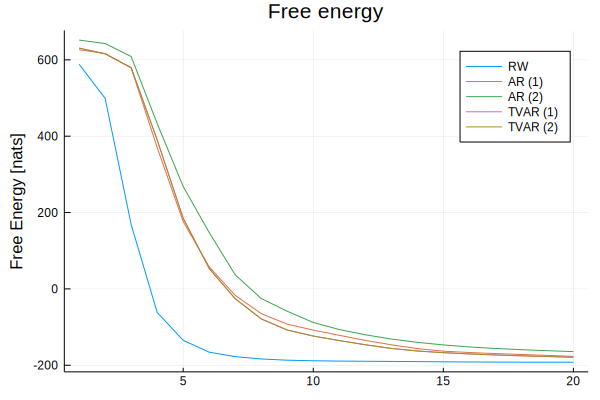

In [40]:
FE_RW = collect(Iterators.flatten(sum(fe_rw, dims=1) ./ totseg))
FE_1 = collect(Iterators.flatten(sum(fe_1, dims=1) ./ totseg))
FE_2 = collect(Iterators.flatten(sum(fe_2, dims=1) ./ totseg))
FE_TV_1 = collect(Iterators.flatten(sum(fe_tv_1, dims=1) ./ totseg))
FE_TV_2 = collect(Iterators.flatten(sum(fe_tv_1, dims=1) ./ totseg))

plot(FE_RW, title="Free energy",  ylabel="Free Energy [nats]", label = "RW")
plot!(FE_1, title="Free energy",  ylabel="Free Energy [nats]", label = "AR (1)")
plot!(FE_2, title="Free energy",  ylabel="Free Energy [nats]", label = "AR (2)")
plot!(FE_TV_1, title="Free energy", ylabel="Free Energy [nats]", label = "TVAR (1)")
plot!(FE_TV_2, title="Free energy", ylabel="Free Energy [nats]", label = "TVAR (2)")

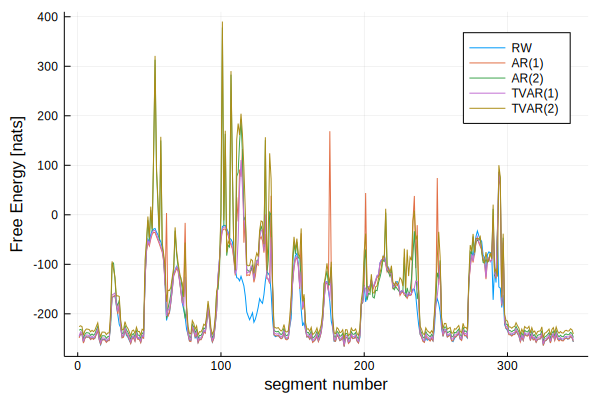

In [41]:
plot(fe_rw[:,end], label="RW", xlabel="segment number", ylabel="Free Energy [nats]")
plot!(fe_1[:,end], label="AR(1)")
plot!(fe_2[:,end], label="AR(2)")
plot!(fe_tv_1[:,end], label="TVAR(1)")
plot!(fe_tv_2[:,end], label="TVAR(2)")
#savefig("figures/speech_free_energy.pdf")

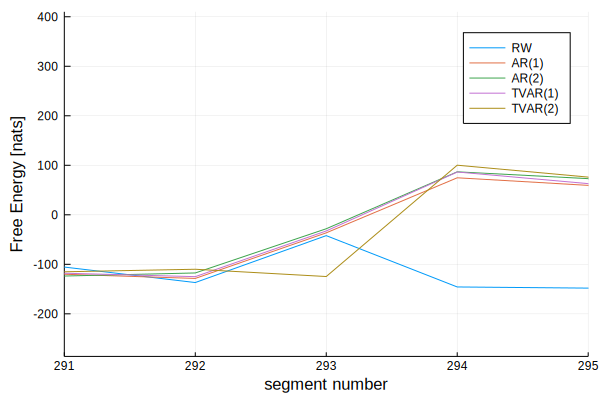

In [42]:
plot(fe_rw[:,end], label="RW", xlabel="segment number", ylabel="Free Energy [nats]")
plot!(fe_1[:,end], label="AR(1)")
plot!(fe_2[:,end], label="AR(2)")
plot!(fe_tv_1[:,end], label="TVAR(1)")
plot!(fe_tv_2[:,end], label="TVAR(2)")
xlims!(291, 295)
#savefig("figures/speech_free_energy_tvar2.pdf")

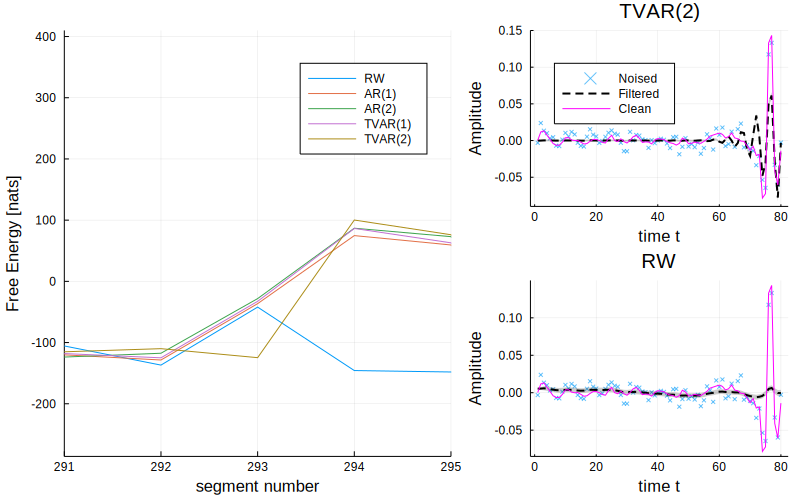

In [43]:
# Advantage of TVAR(2)
segnum = 293

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_tv_2[segnum, :], ribbon=sqrt.(rvx_tv_2[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_tvar = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", title="TVAR(2)", legend=:topleft)

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_rw[segnum, :], ribbon=sqrt.(rvx_rw[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_rw = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", title="RW", legend=false)

plot(fe_rw[:,end], label="RW", xlabel="segment number", ylabel="Free Energy [nats]")
plot!(fe_1[:,end], label="AR(1)")
plot!(fe_2[:,end], label="AR(2)")
plot!(fe_tv_1[:,end], label="TVAR(1)")
plot!(fe_tv_2[:,end], label="TVAR(2)")
plot_fe = xlims!(segnum - 2, segnum + 2)

l = @layout [
    a{0.6w}  [b{0.5h} ; c{0.5h}]
]


plot(plot_fe, plot_tvar, plot_rw , layout=l, size=(800, 500))


#savefig("figures/tvar2vsrw.pdf")

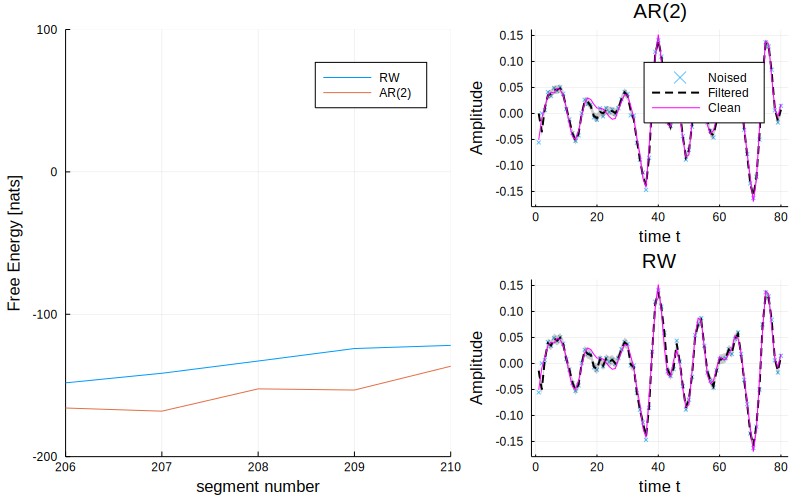

In [44]:
# Advantage of AR(2)
segnum = 208

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_2[segnum, :], ribbon=sqrt.(rvx_2[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_ar = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", title="AR(2)")

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_rw[segnum, :], ribbon=sqrt.(rvx_rw[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_rw = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", legend=false, title="RW")

plot(fe_rw[:,end], label="RW", xlabel="segment number", ylabel="Free Energy [nats]")
#plot!(fe_1[:,end], label="AR(1)")
plot!(fe_2[:,end], label="AR(2)")
#plot!(fe_tv_1[:,end], label="TVAR(1)")
#plot!(fe_tv_2[:,end], label="TVAR(2)")
ylims!(-200, 100)
plot_fe = xlims!(segnum - 2, segnum + 2)

l = @layout [
    a{0.6w}  [b{0.5h} ; c{0.5h}]
]

plot(plot_fe, plot_ar, plot_rw, layout=l, size=(800, 500))
#savefig("figures/ar2vsrw.pdf")

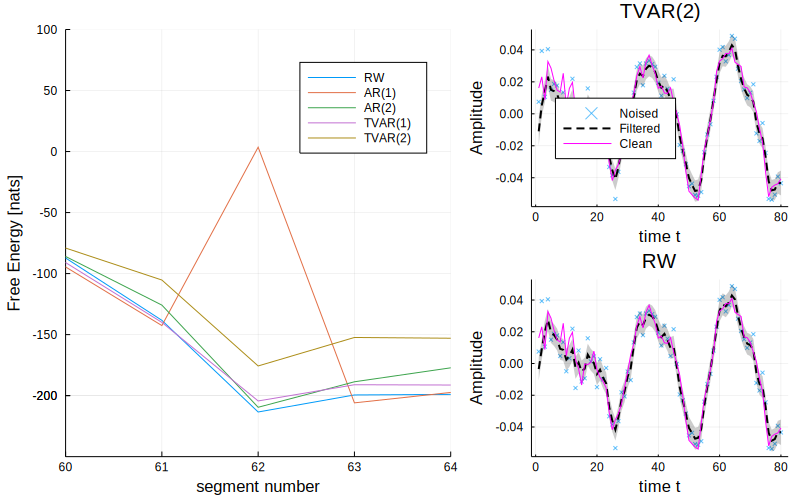

In [45]:
# Advantage of RW
segnum = 62

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_tv_1[segnum, :], ribbon=sqrt.(rvx_tv_1[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_tvar = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", legend=:bottomleft, title="TVAR(2)")

scatter(segment[segnum, :], label="Noised", markershape = :xcross, markeralpha = 0.6, markersize = 2)
plot!(rmx_rw[segnum, :], ribbon=sqrt.(rvx_rw[segnum,:]), label="Filtered", linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black)
plot_rw = plot!(zseg[segnum, :], color = :magenta, linewidth = 1.0, label="Clean", ylabel="Amplitude", xlabel="time t", legend=false, title="RW")

plot(fe_rw[:,end], label="RW", xlabel="segment number", ylabel="Free Energy [nats]")
plot!(fe_1[:,end], label="AR(1)")
plot!(fe_2[:,end], label="AR(2)")
plot!(fe_tv_1[:,end], label="TVAR(1)")
plot!(fe_tv_2[:,end], label="TVAR(2)")
ylims!(-250, 100)
plot_fe = xlims!(segnum - 2, segnum + 2)

l = @layout [
    a{0.6w}  [b{0.5h} ; c{0.5h}]
]

plot(plot_fe, plot_tvar, plot_rw, layout=l, size=(800, 500))
#savefig("figures/rwvstvar2.pdf")

In [46]:
# Reconstructing the signal
l = Int(0.01*fs)
rmx = [rmx_rw, rmx_1, rmx_2, rmx_tv_1, rmx_tv_2]
cleanSpeech = zeros(length(ns))
cleanSpeech[1:l] = rmx[FEs_sorted[1][1]][1, 1:l]

start = l + 1
for i in 2:totseg - 1
    global start
    cleanSpeech[start:start+(l-overlap)] = rmx[FEs_sorted[i][1]][i,overlap:end]
    start = start + l - overlap - 1
end
cleanSpeech[start:start+l-1] = rmx[FEs_sorted[totseg][1]][totseg,1:l]
cleanSpeech = cleanSpeech[1:length(ns)];

In [47]:
# Reconstructing the signal
l = Int(0.01*fs)
rmx = [rmx_rw, rmx_1, rmx_2, rmx_tv_1, rmx_tv_2]
cleanSpeech = zeros(length(ns))
noisedSpeech = zeros(length(ns))
idealSpeech = zeros(length(ns))

cleanSpeech[1:l] = rmx[FEs_sorted[1][1]][1, 1:l]
noisedSpeech[1:l] = segment[1, 1:l]
idealSpeech[1:l] =  zseg[1, 1:l]

start = l + 1
for i in 2:totseg
    global start
    cleanSpeech[start:start+l-1-overlap]  = rmx[FEs_sorted[i][1]][i,overlap+1:end]
    noisedSpeech[start:start+l-1-overlap] = segment[i,overlap+1:end]
    idealSpeech[start:start+l-1-overlap]  =  zseg[i,overlap+1:end]
    start = start + l - overlap - 1
end
# cleanSpeech = cleanSpeech[1:length(ns)];

In [48]:
rmx_tv_1

346×80 Matrix{Float64}:
 -2.89409e-7   -3.76432e-5   -2.45284e-5   …  -0.000135751   7.43815e-5
  7.37828e-5    2.29546e-5    2.15486e-5      -9.12686e-6    1.96769e-5
  1.94516e-5    3.77918e-5   -6.79409e-6       4.13777e-5   -1.36923e-5
 -1.34621e-5   -6.42931e-5    1.01298e-5      -1.61652e-5    8.72709e-6
  8.56712e-6   -4.4735e-5     3.78709e-5       0.000109355  -7.2683e-5
 -7.21291e-5   -6.32016e-5    0.000106263  …  -5.80478e-5    6.02471e-6
  5.89849e-6   -0.000122047   2.59823e-5       6.87823e-5    1.77692e-5
  1.76009e-5   -0.000114895   4.63336e-5      -5.11166e-6    2.87955e-5
  2.84143e-5   -4.83526e-5   -4.98916e-5      -6.05247e-5    6.40282e-5
  6.34541e-5    1.65995e-5    1.94557e-6       7.10302e-6    5.90851e-5
  5.87407e-5    9.65763e-5   -2.23387e-5   …   1.99743e-5    8.29425e-5
  8.24075e-5    0.000139115   1.73674e-5      -1.23794e-5   -3.8555e-5
 -3.84634e-5   -9.01074e-5   -5.16822e-5      -0.000132532  -6.41139e-5
  ⋮                                       

In [49]:
zseg

346×80 Matrix{Float64}:
  0.000122074   0.000824      0.00061037   …   3.05185e-5   -9.15555e-5
  9.15555e-5    6.1037e-5    -0.000152593     -3.05185e-5    0.0
  0.000274667   0.000122074   9.15555e-5       0.0          -3.05185e-5
  0.000183111   0.000122074   0.000152593     -0.000122074   3.05185e-5
  3.05185e-5   -0.00021363   -6.1037e-5       -3.05185e-5    3.05185e-5
 -0.000122074  -9.15555e-5   -0.00021363   …  -0.000183111   3.05185e-5
 -0.00021363    0.0           3.05185e-5      -0.000183111  -0.000122074
  0.0           0.000152593   0.00021363      -0.000122074  -0.000122074
  6.1037e-5    -0.000152593  -0.000183111     -6.1037e-5    -6.1037e-5
  9.15555e-5    0.000152593   0.000122074     -0.000183111  -0.000183111
 -3.05185e-5   -0.000183111  -0.000152593  …   3.05185e-5    0.000183111
 -6.1037e-5     9.15555e-5    0.0             -6.1037e-5    -0.000122074
  0.000183111   0.0           0.0             -0.00021363   -0.00021363
  ⋮                                        

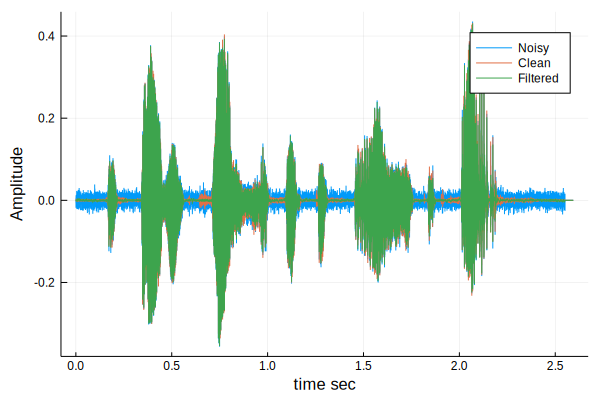

In [60]:
wavwrite(cleanSpeech, "data/speech/filtered.wav")
x = collect((length(ns)/fs)/length(ns):(length(ns)/fs)/length(ns):length(ns)/fs)
plot(x, noisedSpeech, label="Noisy")
plot!(x, idealSpeech, label="Clean")
plot!(x, cleanSpeech, label="Filtered", xlabel="time sec", ylabel="Amplitude")
#savefig("figures/restored.pdf")

### SNR

In [55]:
SNR_before = 10*log10(sum(idealSpeech.^2) / sum((idealSpeech .- noisedSpeech).^2))

13.363308965242647

In [56]:
SNR_after = 10*log10(sum(idealSpeech.^2) / sum((idealSpeech .- cleanSpeech).^2))

17.049954920801245

In [61]:
SNR_after - SNR_before

3.686645955558598

In [289]:
sum(ss[1:100])

0.00010881322796702749

In [153]:
SNR_10*log10(sum(cl.^2) / sum((cl .- cleanSpeech).^2))

-3.0300102498764003

In [71]:
# filtered speech
cleanSpeech = reshape(cleanSpeech, length(cleanSpeech), 1)
buf_fl = SampleBuf{Float64, 2}(cleanSpeech, fs)

20752-frame, 1-channel SampleBuf{Float64, 2}
2.594s sampled at 8000.0Hz
▂▂▃▂▂▄▃▂▂▂▃▆▅▃▄▃▃▃▃▂▃▂▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▃▂▃▁▂▃▃▃▃▃▄▃▃▃▃▃▂▂▃▃▂▂▂▃▃▃▃▂▃▂▂▂▂▂▂▃▂▂▃▃▂▁

In [72]:
# noised speech
buf_ns = SampleBuf{Float64, 2}(ns, fs)

20752-frame, 1-channel SampleBuf{Float64, 2}
2.594s sampled at 8000.0Hz
▅▅▅▅▅▆▆▅▅▅▆▇▇▆▅▆▆▅▅▅▅▅▆▇▇▆▅▅▅▅▆▆▅▅▆▆▅▅▅▆▆▅▅▅▅▆▆▆▆▆▆▅▆▆▆▅▅▅▅▅▅▅▅▆▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅

In [73]:
; python3 spectrograms.py

Traceback (most recent call last):
  File "/Users/apodusenko/Documents/Julia/TVAR_FFG/spectrograms.py", line 1, in <module>
    import matplotlib.pyplot as plt
ModuleNotFoundError: No module named 'matplotlib'


┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278


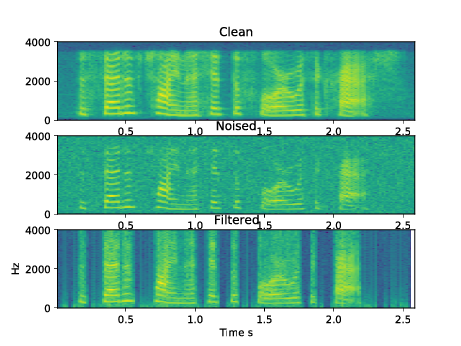

In [386]:
using Images
img = load("data/speech/result.pdf")

In [313]:
anim = @animate for i in 1:segnum
    s = plot(bg = RGB(241/255, 239/255, 239/255))
    ylims!(minimum(segment[i]) - .5, maximum(segment[i]) + .5);
    scatter!(segment[i, :], label="Noised", 
             markershape = :xcross, markeralpha = 0.6,
             markersize = 2)
    
    plot!(rmx[i, :], ribbon=sqrt.(rvx[i, :]),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="Filtered")
    
    plot!(zseg[i, :], color = :magenta, linewidth = 1.0, label="Clean speech")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/jl_gmYwpS", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png"])

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Julia/TVARFFG/data/speech/inference.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/Users/albertpod/Julia/TVARFFG/data/speech/inference.gif")
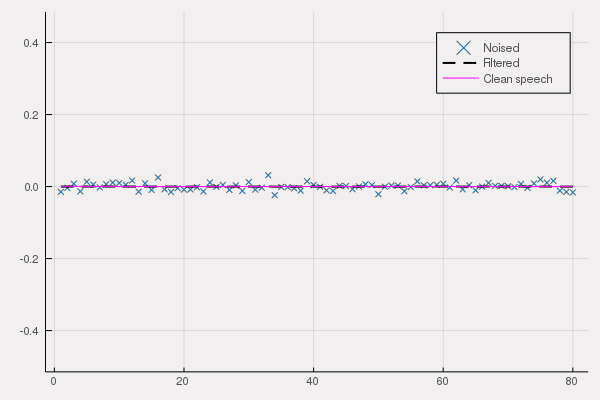

In [314]:
gif(anim, "data/speech/inference.gif", fps = 2)